In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import math
import ast
import progressbar
import os

## Import the data
 First we load all the dataset that we will be using

In [2]:
# Data paths (folder and path are seperated in order to easily check if the pickle version of the file exists)
characters_metadata_path    = {'path':'./data/MovieSummaries/character.metadata',   'extension':'.tsv'}
movies_metadata_path        = {'path':'./data/MovieSummaries/movie.metadata',       'extension':'.tsv'}
movie_summaries_path        = {'path':'./data/MovieSummaries/plot_summaries',       'extension':'.txt'}

imdb_names_path         = {'path':'./data/imdb/imdb_names',         'extension':'.tsv'} 
imdb_principals_path    = {'path':'./data/imdb/imdb_principals',    'extension':'.tsv'}
imdb_ratings_path       = {'path':'./data/imdb/imdb_ratings',       'extension':'.tsv'} 
imdb_titles_path        = {'path':'./data/imdb/imdb_titles',        'extension':'.tsv'}

kaggle_awards_path = {'path':'./data/kaggle/the_oscar_award', 'extension':'.csv'}

# Column names for the MCU datasets (since they are not provided in the datasets themselves)
colnames_charac = ['Wikipedia movie ID', 'Freebase movie ID', 'Movie release date', 'Character name', 'Actor date of birth', 'Actor gender', 'Actor height', 'Actor ethnicity', 'Actor name', 'Actor age', 'Freebase character/actor map ID', 'Freebase character ID', 'Freebase actor ID']
colnames_movie = ['Wikipedia movie ID', 'Freebase movie ID', 'Movie name', 'Movie release date', 'Movie box office revenue', 'Movie runtime', 'Movie languages', 'Movie countries', 'Movie genres'] 
colnames_plot = ['Wikipedia movie ID', 'Plot'] 

In [11]:
pkl_extension = ".pkl"

# Load the dataset given the data dict containing the path and the file extension and check if 
# the pickle exists and either load it or create it and return the dataframe
def load_and_pickle(data_dict, default_load):
    if os.path.exists(data_dict['path'] + pkl_extension):
        print('Pickle file found for {} .'.format(data_dict['path']))
        return pd.read_pickle(data_dict['path'] + pkl_extension)
    else:
        print('No pickle found for {}. Creating it...'.format(data_dict['path']))
        df = default_load(''.join(data_dict.values()))
        df.to_pickle(data_dict['path'] + pkl_extension)
        return df

In [12]:
# Takes ~2 minute without pickles, ~20 seconds with pickles

# Load datasets 
meta_charac_raw = load_and_pickle(characters_metadata_path, lambda path: pd.read_csv(path, names=colnames_charac, sep='\t'))
meta_movie_raw  = load_and_pickle(movies_metadata_path, lambda path: pd.read_csv(path, names=colnames_movie, sep='\t'))
plot            = load_and_pickle(movie_summaries_path, lambda path: pd.read_csv(path, names=colnames_plot, sep='\t'))

# Load IMDB datasets
imdb_names      = load_and_pickle(imdb_names_path, lambda path: pd.read_csv(path, header=0, sep='\t'))
imdb_principals = load_and_pickle(imdb_principals_path, lambda path: pd.read_csv(path, header=0, sep='\t'))
imdb_raitings   = load_and_pickle(imdb_ratings_path, lambda path: pd.read_csv(path, header=0 , sep='\t'))
imdb_title_raw  = load_and_pickle(imdb_titles_path, lambda path: pd.read_csv(path, header=0, sep='\t', dtype= 'string'))

# Load kaggle awards dataset
kaggle_awards_raw = load_and_pickle(kaggle_awards_path, lambda path: pd.read_csv(path, header=0))

Pickle file found for ./data/MovieSummaries/character.metadata.
Pickle file found for ./data/MovieSummaries/movie.metadata.
Pickle file found for ./data/MovieSummaries/plot_summaries.
Pickle file found for ./data/imdb/imdb_names.
Pickle file found for ./data/imdb/imdb_principals.
Pickle file found for ./data/imdb/imdb_ratings.
Pickle file found for ./data/imdb/imdb_titles.
Pickle file found for ./data/kaggle/the_oscar_award.


## Shaping the datasets

Here the goal is simply to make sure that the columns in datasets have correct types and to remove columns that we won't be needing so as not to clutter our analysis

In [16]:
meta_charac = meta_charac_raw.drop(['Freebase movie ID', 'Actor height', 'Freebase character/actor map ID', 'Freebase character ID', 'Freebase actor ID'], axis=1).copy()
meta_movie = meta_movie_raw.drop(['Freebase movie ID', 'Movie runtime', 'Movie languages', 'Movie countries'], axis=1).copy()

# TODO: imdb_names drop (death, known for) ?
# TODO: imdb_principles drop (category, job) ?
# TODO: imdb_title drop (primary/original title) ?
imdb_title = imdb_title_raw.drop(['endYear', 'runtimeMinutes'], axis=1).copy()

kaggle_awards = kaggle_awards_raw.drop(['category'])

,tconst,ordering,nconst,category,job,characters
0,tt0000001,1,nm1588970,self,\N,"[""Self""]"
1,tt0000001,2,nm0005690,director,\N,\N
2,tt0000001,3,nm0374658,cinematographer,director of photography,\N
3,tt0000002,1,nm0721526,director,\N,\N
4,tt0000002,2,nm1335271,composer,\N,\N
...,...,...,...,...,...,...
59085932,tt9916880,5,nm0584014,director,\N,\N
59085933,tt9916880,6,nm0996406,director,principal director,\N
59085934,tt9916880,7,nm1482639,writer,\N,\N
59085935,tt9916880,8,nm2586970,writer,books,\N


In [14]:
print('--- Meta Movie ---')
print(meta_movie.dtypes.to_string())
print('--- Meta Character ---')
print(meta_charac.dtypes.to_string())
print('--- Plot ---')
print(plot.dtypes.to_string())

--- Meta Movie ---
Wikipedia movie ID            int64
Movie name                   object
Movie release date           object
Movie box office revenue    float64
Movie runtime               float64
Movie genres                 object

--- Meta Character ---
Wikipedia movie ID       int64
Movie release date      object
Character name          object
Actor date of birth     object
Actor gender            object
Actor ethnicity         object
Actor name              object
Actor age              float64
--- Plot ---
Wikipedia movie ID     int64
Plot                  object


In [8]:
#TODO Check if we need ot do this ... -> objects are with NaNs I guess...
# meta_movie['Movie name'] = meta_movie['Movie name'].astype(str)

# For consistency we remove day and month from actor date of birth and movie release date.
meta_movie["Movie release date"] = meta_movie["Movie release date"].apply(lambda x: x.split("-")[0] if type(x) == str else x).astype(pd.Int64Dtype())

# turn movie genres into dictionary
meta_movie['Movie genres'] = meta_movie['Movie genres'].apply(ast.literal_eval)
# meta_charac[['Character name', 'Actor gender','Actor ethnicity','Actor name']] = meta_charac[['Character name', 'Actor gender','Actor ethnicity','Actor name']].astype(str)
meta_charac["Movie release date"] = meta_charac["Movie release date"].apply(lambda x: x.split("-")[0] if type(x) == str else x).astype(pd.Int64Dtype())
meta_charac["Actor date of birth"] = meta_charac["Actor date of birth"].apply(lambda x: x.split("-")[0] if type(x) == str else x).astype(pd.Int64Dtype())


## Initial data analysis

TODO : Mieux expliquer

We will start by filtering the data by adding the IMDb scores. To do this we will need to have a look at the IMDb dataset.  Once the filtering id finished, we will then analyse what we have left.

In [9]:
# For consistency we remove day and month from actor date of birth and movie release date.
meta_movie["Movie release date"] = meta_movie["Movie release date"].apply(lambda x: x.split("-")[0] if type(x) == str else x).astype(pd.Int64Dtype())
meta_charac["Movie release date"] = meta_charac["Movie release date"].apply(lambda x: x.split("-")[0] if type(x) == str else x).astype(pd.Int64Dtype())
meta_charac["Actor date of birth"] = meta_charac["Actor date of birth"].apply(lambda x: x.split("-")[0] if type(x) == str else x).astype(pd.Int64Dtype())

# turn movie genres into dictionary
meta_movie['Movie genres'] = meta_movie['Movie genres'].apply(ast.literal_eval)

,Wikipedia movie ID,Movie name,Movie release date,Movie box office revenue,Movie genres
0,975900,Ghosts of Mars,2001,14010832.0,"{'/m/01jfsb': 'Thriller', '/m/06n90': 'Science..."
1,3196793,Getting Away with Murder: The JonBenét Ramsey ...,2000,NaN,"{'/m/02n4kr': 'Mystery', '/m/03bxz7': 'Biograp..."
2,28463795,Brun bitter,1988,NaN,"{'/m/0lsxr': 'Crime Fiction', '/m/07s9rl0': 'D..."
3,9363483,White Of The Eye,1987,NaN,"{'/m/01jfsb': 'Thriller', '/m/0glj9q': 'Erotic..."
4,261236,A Woman in Flames,1983,NaN,{'/m/07s9rl0': 'Drama'}
...,...,...,...,...,...
81736,35228177,Mermaids: The Body Found,2011,NaN,{'/m/07s9rl0': 'Drama'}
81737,34980460,Knuckle,2011,NaN,"{'/m/03bxz7': 'Biographical film', '/m/07s9rl0..."
81738,9971909,Another Nice Mess,1972,NaN,"{'/m/06nbt': 'Satire', '/m/01z4y': 'Comedy'}"
81739,913762,The Super Dimension Fortress Macross II: Lover...,1992,NaN,"{'/m/06n90': 'Science Fiction', '/m/0gw5n2f': ..."


## 1.2 Data augmentation
We will start by aumenting out dataset by adding the IMDb scores to their corresponding movie, we want every movie in our dataset to have a rating, so we will use an **inner merge** (default) on the **title** and **year**. 

But first will need to have a look at the IMDb dataset.

In [10]:
#takes 25s to run
print("     ----- Title data sample -----")
display(imdb_title.sample(5))
print("     ----- Raiting data overview -----")
display(imdb_raitings.sample(5))

     ----- Title data sample -----


,tconst,titleType,primaryTitle,originalTitle,startYear
4283464,tt16150194,video,My Daughter's Hot Friend: Vol. 8,My Daughter's Hot Friend: Vol. 8,2021
7231972,tt3037302,short,Café Milonga,Café Milonga,2013
8076799,tt4967776,tvEpisode,Orlando Jones,Orlando Jones,2015
470572,tt0489772,movie,Lots of Ice and a Little Bit of Water,Muito Gelo e Dois Dedos D'Água,2006
2107443,tt12053560,tvEpisode,2668,2668,2015


     ----- Raiting data overview -----


Wikipedia movie ID                        Movie name  \
0                  975900                    Ghosts of Mars   
1                28463795                       Brun bitter   
2                10408933          Alexander's Ragtime Band   
3                  175026                     Sarah and Son   
4                  171005                           Henry V   
...                   ...                               ...   
35607            24209227  The Time, the Place and the Girl   
35608            15394941                       Gopi Kishan   
35609            23851782                   The Ghost Train   
35610            34980460                           Knuckle   
35611             9971909                 Another Nice Mess   

       Movie release date  Movie box office revenue  \
0                    2001                14010832.0   
1                    1988                       NaN   
2                    1938                 3600000.0   
3                    1930                       NaN   
4                    1989                10161099.0   
...                   ...                       ...   
35607                1946                       NaN   
35608                1994                       NaN   
35609                1941                       NaN   
35610                2011                       NaN   
35611                1972                       NaN   

                                            Movie genres  \
0      {'/m/01jfsb': 'Thriller', '/m/06n90': 'Science...   
1      {'/m/0lsxr': 'Crime Fiction', '/m/07s9rl0': 'D...   
2      {'/m/04t36': 'Musical', '/m/01z4y': 'Comedy', ...   
3      {'/m/07s9rl0': 'Drama', '/m/01g6gs': 'Black-an...   
4      {'/m/04xvh5': 'Costume drama', '/m/082gq': 'Wa...   
...                                                  ...   
35607  {'/m/05p553': 'Comedy film', '/m/02l7c8': 'Rom...   
35608  {'/m/07s9rl0': 'Drama', '/m/02kdv5l': 'Action'...   
35609  {'/m/0lsxr': 'Crime Fiction', '/m/01jfsb': 'Th...   
35610  {'/m/03bxz7': 'Biographical film', '/m/07s9rl0...   
35611       {'/m/06nbt': 'Satire', '/m/01z4y': 'Comedy'}   

                          originalTitle  startYear    IMDb_ID  averageRating  \
0                        Ghosts of Mars       2001  tt0228333            4.9   
1                           Brun bitter       1988  tt0094806            5.6   
2              Alexander's Ragtime Band       1938  tt0029852            6.8   
3                         Sarah and Son       1930  tt0021335            5.4   
4                               Henry V       1989  tt0097499            7.5   
...                                 ...        ...        ...            ...   
35607  The Time, the Place and the Girl       1946  tt0039038            5.9   
35608                       Gopi Kishan       1994  tt0109922            5.8   
35609                   The Ghost Train       1941  tt0033660            6.2   
35610                           Knuckle       2011  tt1606259            6.8   
35611                 Another Nice Mess       1972  tt0362411            5.8   

       numVotes  
0         56930  
1            41  
2          2270  
3           300  
4         31214  
...         ...  
35607       348  
35608       964  
35609      1582  
35610      3194  
35611       112  

[35612 rows x 10 columns]

In [17]:
imdb_movieTitle = imdb_title[imdb_title['titleType'] == 'movie'].copy() #keep only movies
imdb_movieTitle = imdb_movieTitle[imdb_movieTitle['startYear'] != '\\N'].copy() #remove nan years
imdb_movieTitle['startYear'] = imdb_movieTitle['startYear'].astype(int) # turn year to int
imdb_names.rename(columns={'nconst':'IMDb_actor_ID'}, inplace=True) #rename actor id for ease of use

# Merging the datasets
movies = meta_movie\
            .merge(imdb_movieTitle[['originalTitle','startYear','tconst']], left_on= ['Movie name', 'Movie release date'], right_on= ['originalTitle','startYear'], how= 'inner')\
            .merge(imdb_raitings, how ='inner')
movies.rename(columns={"tconst":"IMDb_ID"}, inplace= True) #rename IMDb ID for ease of use

print("--- Movie dataset size ---")
print(movies.shape)

--- Movie dataset size ---
(35612, 11)


The merge has redused our dataset alot, we this this is due to bad title matching (as we are merging on the title)
## 1.3 Data analysis (continued)

We will now have a look at the NaNs in the resulting dataset

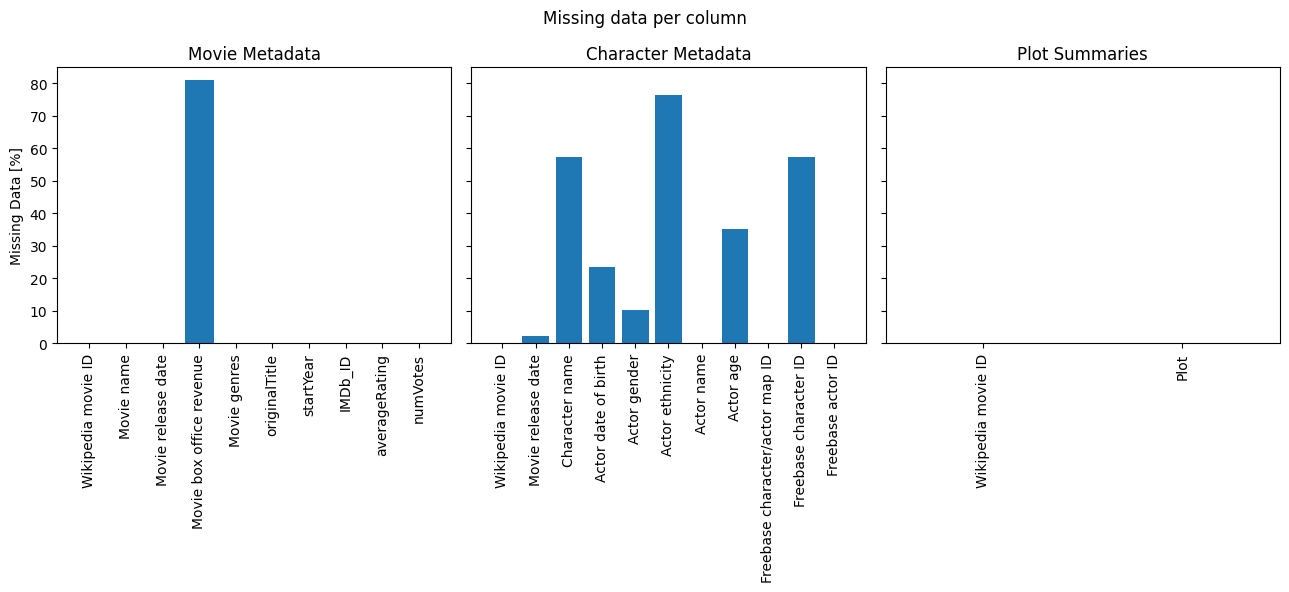

--- Dataset shapes ---
Movies metadata: (35612, 11)
Character metadata: (35612, 11)
Plot summaries: (42303, 2)


In [11]:
# Calculating missing data
missing_movie = movies.isnull().sum() * 100 / len(movies)
missing_char = meta_charac.isnull().sum() * 100 / len(meta_charac)
missing_plot = plot.isnull().sum() * 100 / len(plot)

#Plotting
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(13, 6), sharey=True)
fig.suptitle('Missing data per column')

ax1.set(ylabel= 'Missing Data [%]')
ax1.bar(missing_movie.index, missing_movie.values)
ax1.tick_params(axis='x', labelrotation = 90)
ax1.set_title("Movie Metadata")
ax2.bar(missing_char.index, missing_char.values)
ax2.tick_params(axis='x', labelrotation = 90)
ax2.set_title("Character Metadata")
ax3.bar(missing_plot.index, missing_plot.values)
ax3.tick_params(axis='x', labelrotation = 90)
ax3.set_title("Plot Summaries")
plt.tight_layout()
plt.show()

print("--- Dataset shapes ---")
print("Movies metadata: {}" .format(movies.shape))
print("Character metadata: {}" .format(movies.shape))
print("Plot summaries: {}" .format(plot.shape))

*Observation:* From this initial analysis, it's evident that there is a significant amount of missing data.

*Action:* To address this, we've decided to drop certain actor features, specifically `actor height`, `actor ethnicity`, and `actor age`, recognizing the high incidence of missing values in these columns.


In [11]:
charac = meta_charac.drop(columns=['Actor ethnicity', 'Actor height', 'Actor age'])

Now lets work on the movie genres, we can use the fact that they are a dictionary to have a look at their frequency

In [18]:
# N.B Takes 20s to run
def count_genres(dictionary):
    return pd.Series(list(dictionary.values())).value_counts()

# Apply the custom function to the column
genre_counts = movies['Movie genres'].apply(count_genres).fillna(0).sum()


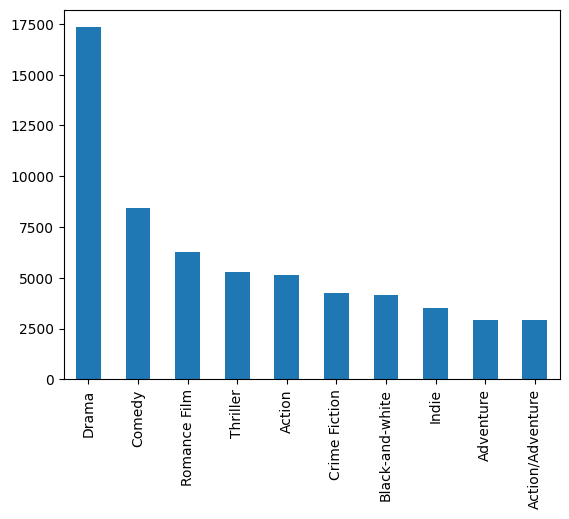

In [13]:
# Plot top 10 most represented genres
genre_counts = genre_counts.sort_values(ascending=False).head(10)
genre_counts.plot.bar()
plt.title("Top 10 genres with highest film count")
plt.xlabel("Genre")
plt.ylabel("Count")
plt.show()

*Observation:* Based on the graph, it is evident that drama movies are significantly more represented than other genres.

*Decision:* In light of this observation, we have decided to focus our analysis primarily on drama movies, considering their substantial representation in the dataset.

# 1.4 Filtering
We are proceeding to filter outliers in the dataset. The goal is to identify and exclude any data points that deviate significantly from the general pattern, ensuring that our analysis is not unduly influenced by extreme values.

In [22]:
#Save an unfieltered version of movies
movies_uf = movies.copy()
# TODO: Comments
def get_top_actors(movies, imdb_principals, top_n=3):
    imdb_principal_actors = imdb_principals.query('category == "actor" | category == "actress"')
    imdb_principal_actors_valid = imdb_principal_actors[(imdb_principal_actors["IMDb_ID"].isin(movies["IMDb_ID"].values.tolist())) & 
                                                        (imdb_principal_actors["ordering"] <= top_n)]

# There are outliers in the film duration. We are removing them to standardise our data
max_movie_runtime = 200 #minutes
min_movie_runtime = 40 #minutes
movies = movies.query('`Movie runtime` <= @max_movie_runtime and `Movie runtime` >= @min_movie_runtime').copy()

# To ensure enough films are available per year, we are removing the older and newer years
max_movie_year = 2012
min_movie_year = 1930
movies = movies.query('`Movie release date` <= @max_movie_year and `Movie release date` >= @min_movie_year').copy()


# 1.5 Final Data Analysis 
Lets have a look at what our final database looks like

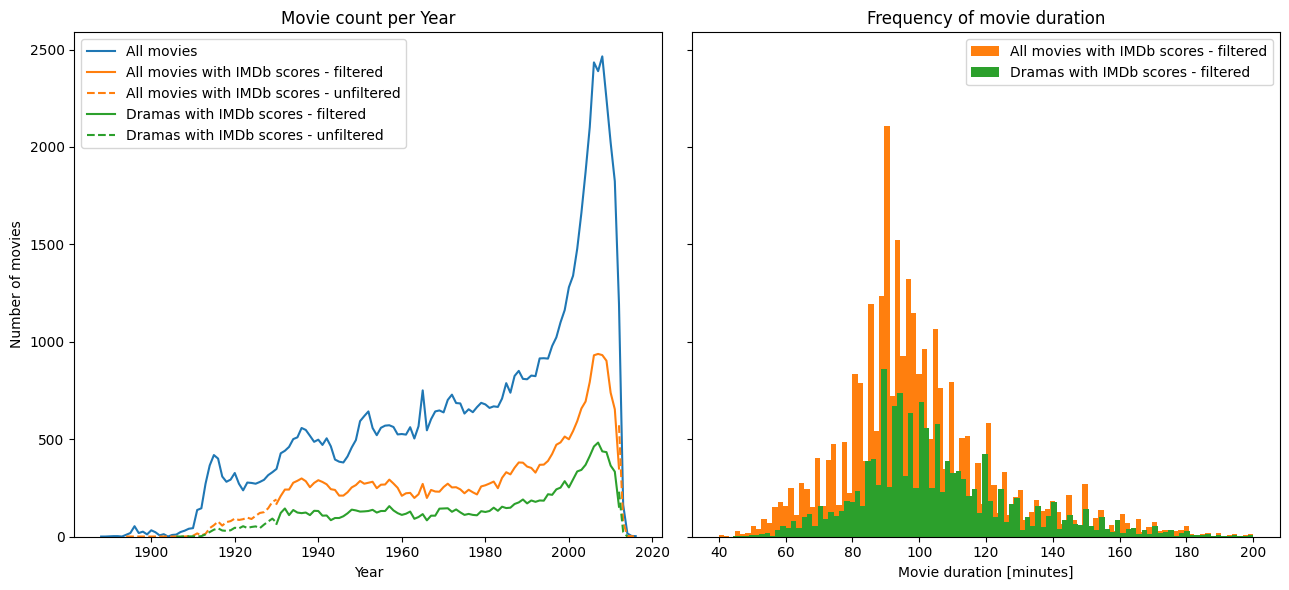

In [23]:
# get unfiltered movies with IMDb scores -> We select that years  that will not be plotted withg the filtered data
movies_ufR = movies_uf.query('`Movie release date` >= @max_movie_year').copy()
movies_ufL = movies_uf.query('`Movie release date` <= @min_movie_year').copy()

# get filtered and unfiltered drama movies
drama_movies = movies[movies['Movie genres'].apply(lambda x: 'Drama' in x.values())]
drama_movies_ufR = movies_uf[movies_uf['Movie genres'].apply(lambda x: 'Drama' in x.values())].query('`Movie release date` >= @max_movie_year').copy()
drama_movies_ufL = movies_uf[movies_uf['Movie genres'].apply(lambda x: 'Drama' in x.values())].query('`Movie release date` <= @min_movie_year').copy()

#There is a movie with a typo in the original dataset, we can change this manually
meta_movie["Movie release date"][meta_movie["Movie release date"]==1010] = 2010

# Count all movies without merging with IMDb
all_movie_counts = meta_movie['Wikipedia movie ID'].groupby(meta_movie['Movie release date']).count()

# Count movies after merging with IMDb with and wothout filtering
movie_counts = movies['Wikipedia movie ID'].groupby(movies['Movie release date']).count()
movie_counts_ufL = movies_ufL['Wikipedia movie ID'].groupby(movies_ufL['Movie release date']).count()
movie_counts_ufR = movies_ufR['Wikipedia movie ID'].groupby(movies_ufR['Movie release date']).count()

# Count drama movies aafter merging with IMDb with and without filtering
drama_counts = drama_movies['Wikipedia movie ID'].groupby(drama_movies['Movie release date']).count()
drama_counts_ufL = drama_movies_ufL['Wikipedia movie ID'].groupby(drama_movies_ufL['Movie release date']).count()
drama_counts_ufR = drama_movies_ufR['Wikipedia movie ID'].groupby(drama_movies_ufR['Movie release date']).count()

#       ----- PLOT -----
fig, axes = plt.subplots(1, 2, figsize=(13, 6), sharey= True)

# subplot 1: plot all movie counts
axes[0].set_title('Movie count per Year')
axes[0].set_ylabel('Number of movies')
axes[0].set_xlabel('Year')
axes[0].plot(all_movie_counts.index, all_movie_counts.values, color= 'C0', label= 'All movies')
axes[0].plot(movie_counts.index, movie_counts.values, color= 'C1', label= 'All movies with IMDb scores - filtered')
axes[0].plot(movie_counts_ufL.index, movie_counts_ufL.values, color= 'C1', linestyle = '--',label= 'All movies with IMDb scores - unfiltered')
axes[0].plot(movie_counts_ufR.index, movie_counts_ufR.values, color= 'C1', linestyle = '--')
axes[0].plot(drama_counts.index, drama_counts.values, color = 'C2', label='Dramas with IMDb scores - filtered')
axes[0].plot(drama_counts_ufL.index, drama_counts_ufL.values, color ='C2', linestyle = '--', label='Dramas with IMDb scores - unfiltered')
axes[0].plot(drama_counts_ufR.index, drama_counts_ufR.values, color ='C2', linestyle = '--')
axes[0].legend(loc="upper left")

axes[1].set_title('Frequency of movie duration')
axes[1].set_xlabel('Movie duration [minutes]')
axes[1].hist(movies['Movie runtime'], bins = 100, color = 'C1', label= 'All movies with IMDb scores - filtered')
axes[1].hist(drama_movies['Movie runtime'], bins = 100, color = 'C2', label= 'Dramas with IMDb scores - filtered')
axes[1].legend(loc="upper right")

plt.tight_layout()
plt.show()

*Observation:* We have dramatically reduced the amount of films in our dataset, however the distribution of the drama movies is similar to the all movies with IMDb score in both `Release date` and `Film duration`. We still have close to 15'000 drama movies to base our analysis on.

In [24]:
movies.describe()

,Wikipedia movie ID,Movie release date,Movie box office revenue,Movie runtime,startYear,averageRating,numVotes
count,2.887200e+04,28872.0,6.706000e+03,28872.000000,28872.000000,28872.000000,2.887200e+04
mean,1.457100e+07,1979.861769,5.284061e+07,99.657200,1979.861769,6.153723,2.051200e+04
std,1.113637e+07,25.175801,1.168245e+08,23.525687,25.175801,1.078746,9.017755e+04
min,3.217000e+03,1930.0,1.140800e+04,40.000000,1930.000000,1.100000,5.000000e+00
25%,3.859155e+06,1957.0,2.460834e+06,86.000000,1957.000000,5.500000,2.330000e+02
50%,1.255575e+07,1986.0,1.295155e+07,96.000000,1986.000000,6.300000,1.050000e+03
75%,2.448322e+07,2003.0,4.842016e+07,109.000000,2003.000000,6.900000,5.587250e+03
max,3.749236e+07,2012.0,2.782275e+09,200.000000,2012.000000,9.700000,2.818516e+06


In [24]:
drama_movies.describe()

,Wikipedia movie ID,Movie release date,Movie box office revenue,Movie runtime,startYear,averageRating,numVotes
count,1.435200e+04,14352.0,3.486000e+03,14352.000000,14352.000000,14352.000000,1.435200e+04
mean,1.404152e+07,1980.611901,4.367115e+07,105.133794,1980.611901,6.353728,2.250638e+04
std,1.102451e+07,24.817641,9.770477e+07,24.020227,24.817641,0.961586,1.026533e+05
min,3.746000e+03,1930.0,1.140800e+04,41.000000,1930.000000,1.100000,5.000000e+00
25%,3.660461e+06,1959.0,2.019208e+06,90.000000,1959.000000,5.800000,2.640000e+02
50%,1.163850e+07,1987.0,1.015902e+07,100.000000,1987.000000,6.400000,1.182000e+03
75%,2.407827e+07,2003.0,4.085694e+07,117.000000,2003.000000,7.000000,6.450500e+03
max,3.749236e+07,2012.0,2.185372e+09,200.000000,2012.000000,9.700000,2.818516e+06


In [26]:
drama_movies

,Wikipedia movie ID,Movie name,Movie release date,Movie box office revenue,Movie runtime,Movie genres,originalTitle,startYear,IMDb_ID,averageRating,numVotes
1,28463795,Brun bitter,1988,NaN,83.0,"{'/m/0lsxr': 'Crime Fiction', '/m/07s9rl0': 'D...",Brun bitter,1988,tt0094806,5.6,41
3,175026,Sarah and Son,1930,NaN,86.0,"{'/m/07s9rl0': 'Drama', '/m/01g6gs': 'Black-an...",Sarah and Son,1930,tt0021335,5.4,300
4,171005,Henry V,1989,10161099.0,137.0,"{'/m/04xvh5': 'Costume drama', '/m/082gq': 'Wa...",Henry V,1989,tt0097499,7.5,31214
5,77856,Mary Poppins,1964,102272727.0,139.0,"{'/m/0hj3myq': 'Children's/Family', '/m/04t36'...",Mary Poppins,1964,tt0058331,7.8,181857
9,21344842,Middle Age Spread,1979,NaN,98.0,"{'/m/05p553': 'Comedy film', '/m/07s9rl0': 'Dr...",Middle Age Spread,1979,tt0079552,6.0,37
...,...,...,...,...,...,...,...,...,...,...,...
35595,21772949,Casbah,1948,NaN,94.0,"{'/m/0lsxr': 'Crime Fiction', '/m/04t36': 'Mus...",Casbah,1948,tt0040214,6.0,549
35596,24997872,Pokkiri Raja,2010,NaN,136.0,{'/m/07s9rl0': 'Drama'},Pokkiri Raja,2010,tt1667852,5.1,1366
35599,25919941,The Kreutzer Sonata,2008,NaN,99.0,"{'/m/068d7h': 'Romantic drama', '/m/02l7c8': '...",The Kreutzer Sonata,2008,tt1172063,5.6,391
35603,28373912,Jan Zizka,1956,NaN,105.0,"{'/m/07s9rl0': 'Drama', '/m/082gq': 'War film'}",Jan Zizka,1956,tt0048223,6.8,174


## Main character extraction

In [ ]:
def get_top_actors(movies, imdb_principals, top_n=3):
    imdb_principal_actors = imdb_principals.query('category == "actor" | category == "actress"')
    imdb_principal_actors_valid = imdb_principal_actors[(imdb_principal_actors["IMDb_ID"].isin(movies["IMDb_ID"].values.tolist())) & 
                                                        (imdb_principal_actors["ordering"] <= top_n)]

    movie_actors = []
    bar = progressbar.ProgressBar(maxval=len(movies["IMDb_ID"])).start()
    for idx, id in enumerate(movies["IMDb_ID"]):
        tmp = imdb_principal_actors_valid.loc[imdb_principal_actors_valid["IMDb_ID"] == id][["ordering", "IMDb_actor_ID"]]
        for _, row in tmp.iterrows():
            movie_actors.append([id, row["IMDb_actor_ID"], row["ordering"]])
        bar.update(idx)

    movie_actors = pd.DataFrame(movie_actors, columns=['IMDb_ID', 'actor', 'ordering'])
    return movie_actors

In [ ]:
imdb_principals.rename(columns={'nconst':'IMDb_actor_ID'}, inplace=True)
imdb_principals.rename(columns={'tconst':'IMDb_ID'}, inplace=True)

movie_actors = get_top_actors(movies, imdb_principals, 1)
movie_actors.head()

In [ ]:
# creation of the DF only with valid actors

movies = movies[movies["IMDb_ID"].isin(movie_actors["IMDb_ID"].unique().tolist())]
movies.head()

In [50]:
imdb_names

,IMDb_actor_ID,primaryName,birthYear,deathYear,primaryProfession,knownForTitles
0,nm0000001,Fred Astaire,1899,1987,"soundtrack,actor,miscellaneous","tt0031983,tt0050419,tt0053137,tt0072308"
1,nm0000002,Lauren Bacall,1924,2014,"actress,soundtrack","tt0117057,tt0037382,tt0038355,tt0075213"
2,nm0000003,Brigitte Bardot,1934,\N,"actress,soundtrack,music_department","tt0056404,tt0057345,tt0049189,tt0054452"
3,nm0000004,John Belushi,1949,1982,"actor,soundtrack,writer","tt0077975,tt0078723,tt0080455,tt0072562"
4,nm0000005,Ingmar Bergman,1918,2007,"writer,director,actor","tt0069467,tt0083922,tt0050976,tt0050986"
...,...,...,...,...,...,...
13009996,nm9993714,Romeo del Rosario,\N,\N,"animation_department,art_department","tt14069590,tt2455546,tt11657662"
13009997,nm9993716,Essias Loberg,\N,\N,NaN,\N
13009998,nm9993717,Harikrishnan Rajan,\N,\N,cinematographer,tt8736744
13009999,nm9993718,Aayush Nair,\N,\N,cinematographer,tt8736744


In [53]:
# on pourrait peut-être faire toute l'analyse des genres et nans après le merge final de la case au dessus
# takes ~10 seconds
actors = movie_actors.merge(movies[['Wikipedia movie ID', 'Movie name', 'Movie release date', 'IMDb_ID']], on='IMDb_ID')
actors = actors.merge(imdb_names[['primaryName', 'IMDb_actor_ID']], left_on='actor', right_on='IMDb_actor_ID').drop('IMDb_actor_ID', axis=1)
actors

,IMDb_ID,actor,ordering,Wikipedia movie ID,Movie name,Movie release date,primaryName
0,tt0228333,nm0000449,1,975900,Ghosts of Mars,2001,Natasha Henstridge
1,tt0114508,nm0000449,1,689763,Species,1995,Natasha Henstridge
2,tt0120841,nm0000449,1,704406,Species II,1998,Natasha Henstridge
3,tt0129884,nm0000449,1,761361,Dog Park,1998,Natasha Henstridge
4,tt0244196,nm0000449,1,355807,Second Skin,2000,Natasha Henstridge
...,...,...,...,...,...,...,...
34269,tt0228829,nm0848520,1,31026778,Secreto eterno,1942,Marina Tamayo
34270,tt0100666,nm0056492,1,7761830,Spaced Invaders,1990,Douglas Barr
34271,tt0048223,nm0827409,1,28373912,Jan Zizka,1956,Zdenek Stepánek
34272,tt1606259,nm4774206,1,34980460,Knuckle,2011,James Quinn McDonagh


# Awards feature

As a specific actor feature, we want to use the number of awards won. To do this we use a kaggle dataset ([link](https://www.kaggle.com/datasets/unanimad/the-oscar-award/code)).


In [58]:

kaggle_awards = pd.read_csv('./data/kaggle/the_oscar_award.csv', header=0)
display(kaggle_awards)

,year_film,year_ceremony,ceremony,category,name,film,winner
0,1927,1928,1,ACTOR,Richard Barthelmess,The Noose,False
1,1927,1928,1,ACTOR,Emil Jannings,The Last Command,True
2,1927,1928,1,ACTRESS,Louise Dresser,A Ship Comes In,False
3,1927,1928,1,ACTRESS,Janet Gaynor,7th Heaven,True
4,1927,1928,1,ACTRESS,Gloria Swanson,Sadie Thompson,False
...,...,...,...,...,...,...,...
10760,2022,2023,95,HONORARY AWARD,"To Euzhan Palcy, a masterful filmmaker who bro...",NaN,True
10761,2022,2023,95,HONORARY AWARD,"To Diane Warren, for her genius, generosity an...",NaN,True
10762,2022,2023,95,HONORARY AWARD,"To Peter Weir, a fearless and consummate filmm...",NaN,True
10763,2022,2023,95,GORDON E. SAWYER AWARD,Iain Neil,NaN,True


We should filter to keep only movies that are in our dataset

In [59]:
kaggle_awards = kaggle_awards[kaggle_awards['name'].isin(actors['primaryName'].unique())]
kaggle_awards = kaggle_awards[kaggle_awards['film'].isin(movies['Movie name'].unique())]
kaggle_awards

,year_film,year_ceremony,ceremony,category,name,film,winner
0,1927,1928,1,ACTOR,Richard Barthelmess,The Noose,False
1,1927,1928,1,ACTOR,Emil Jannings,The Last Command,True
4,1927,1928,1,ACTRESS,Gloria Swanson,Sadie Thompson,False
35,1928,1929,2,ACTOR,George Bancroft,Thunderbolt,False
37,1928,1929,2,ACTOR,Chester Morris,Alibi,False
...,...,...,...,...,...,...,...
10158,2018,2019,91,ACTRESS IN A SUPPORTING ROLE,Marina de Tavira,Roma,False
10270,2019,2020,92,ACTOR IN A LEADING ROLE,Joaquin Phoenix,Joker,True
10279,2019,2020,92,ACTRESS IN A LEADING ROLE,Saoirse Ronan,Little Women,False
10280,2019,2020,92,ACTRESS IN A LEADING ROLE,Charlize Theron,Bombshell,False


Text(0, 0.5, 'Percentage of missing data [%]')

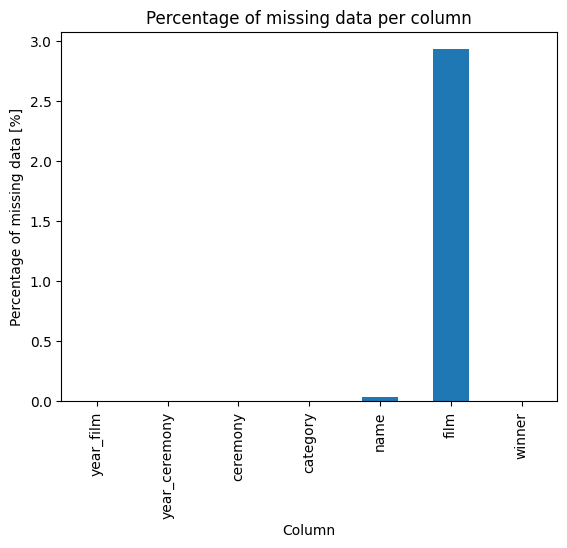

In [42]:
kaggle_nans = kaggle_awards.isnull().sum() * 100 / len(kaggle_awards)
kaggle_nans.plot(kind='bar')
plt.title('Percentage of missing data per column')
plt.xlabel('Column')
plt.ylabel('Percentage of missing data [%]')

As we can see, the dataset is mostly NaNs free.

Let's now define a function to get the number of awards won by a given actor up until a given year. For this feature we will only consider the number of awards that the actor won before the movie was released. Using this function we will be able to add a new column in our previous dataframe. 

The function allow counting both the amount of awards won but also the number of nominations

In [80]:
def count_awards(actor_name, year, win):
    filtered = kaggle_awards.query("year_film < {} & winner == {} & name == \"{}\"".format(year, win, actor_name))
    return len(filtered)

In [83]:
# Takes ~40 seconds
actors['awards'] = [count_awards(row['primaryName'], row['Movie release date'], True) for (index, row) in actors.iterrows()]


,year_film,year_ceremony,ceremony,category,name,film,winner
0,1927,1928,1,ACTOR,Richard Barthelmess,The Noose,False
1,1927,1928,1,ACTOR,Emil Jannings,The Last Command,True
4,1927,1928,1,ACTRESS,Gloria Swanson,Sadie Thompson,False
35,1928,1929,2,ACTOR,George Bancroft,Thunderbolt,False
37,1928,1929,2,ACTOR,Chester Morris,Alibi,False
...,...,...,...,...,...,...,...
10158,2018,2019,91,ACTRESS IN A SUPPORTING ROLE,Marina de Tavira,Roma,False
10270,2019,2020,92,ACTOR IN A LEADING ROLE,Joaquin Phoenix,Joker,True
10279,2019,2020,92,ACTRESS IN A LEADING ROLE,Saoirse Ronan,Little Women,False
10280,2019,2020,92,ACTRESS IN A LEADING ROLE,Charlize Theron,Bombshell,False


In [84]:
actors

,IMDb_ID,actor,ordering,Wikipedia movie ID,Movie name,Movie release date,primaryName,awards
0,tt0228333,nm0000449,1,975900,Ghosts of Mars,2001,Natasha Henstridge,0
1,tt0114508,nm0000449,1,689763,Species,1995,Natasha Henstridge,0
2,tt0120841,nm0000449,1,704406,Species II,1998,Natasha Henstridge,0
3,tt0129884,nm0000449,1,761361,Dog Park,1998,Natasha Henstridge,0
4,tt0244196,nm0000449,1,355807,Second Skin,2000,Natasha Henstridge,0
...,...,...,...,...,...,...,...,...
34269,tt0228829,nm0848520,1,31026778,Secreto eterno,1942,Marina Tamayo,0
34270,tt0100666,nm0056492,1,7761830,Spaced Invaders,1990,Douglas Barr,0
34271,tt0048223,nm0827409,1,28373912,Jan Zizka,1956,Zdenek Stepánek,0
34272,tt1606259,nm4774206,1,34980460,Knuckle,2011,James Quinn McDonagh,0


In [92]:
actors.awards.unique()

array([0, 1, 2, 3, 4])